In [1]:
import numpy as np
import pandas as pd

In [2]:
from importlib import reload

In [3]:
import pdb
try: c45 = reload(c45)
except: import c45

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [6]:
def encode_classes(l, classes):
    classes = np.array(classes)
    return [np.argmax([x==classes]) for x in l]

# Trying imprecise method

In [63]:
import math
import numpy as np
class C45_credal:
    """Creates a decision tree with C4.5 algorithm"""
    def __init__(self, pathToData,pathToNames, min_node_size=1, s=0, max_height=None):
        self.filePathToData = pathToData
        self.filePathToNames = pathToNames
        self.data = []
        self.classes = []
        self.numAttributes = -1 
        self.attrValues = {}
        self.attributes = []
        self.tree = None
        self.min_node_size = min_node_size
        self.s = s
        self.max_height = max_height

    def predict(self, x):
        cur_node = self.tree
        while not cur_node.isLeaf:
            xidx = np.argmax(np.array(self.attributes)==cur_node.label)
            t = cur_node.threshold if cur_node.threshold is not None else 0
            if x[xidx]<=t:
                cur_node = cur_node.children[0]
            else:
                cur_node = cur_node.children[1]
        return cur_node.label
    
    def predict_list(self, xs):
        ps = [self.predict(x) for x in xs]
        return ps
            

    def fetchData(self):
        with open(self.filePathToNames, "r") as file:
            classes = file.readline()
            self.classes = [x.strip() for x in classes.split(",")]
            #add attributes
            for line in file:
                [attribute, values] = [x.strip() for x in line.split(":")]
                values = [x.strip() for x in values.split(",")]
                self.attrValues[attribute] = values
        self.numAttributes = len(self.attrValues.keys())
        self.attributes = list(self.attrValues.keys())
        with open(self.filePathToData, "r") as file:
            for line in file:
                row = [x.strip() for x in line.split(",")]
                if row != [] or row != [""]:
                    self.data.append(row)
                    
    def fetchDataSet(self, ds, y_feat):
        self.classes = list(ds[y_feat].unique())
        for f in ds.drop(y_feat,1):
            self.attrValues[f] = list(ds[f].unique())        
        
        self.numAttributes = len(self.attrValues.keys())
        self.attributes = list(self.attrValues.keys())
        self.ds = ds

    def preprocessData(self):
        for index,row in enumerate(self.data):
            for attr_index in range(self.numAttributes):
                if(not self.isAttrDiscrete(self.attributes[attr_index])):
                    self.data[index][attr_index] = float(self.data[index][attr_index])

    def printTree(self):
        self.printNode(self.tree)

    def printNode(self, node, indent=""):
        if not node.isLeaf:
            if node.threshold is None:
                #discrete
                for index,child in enumerate(node.children):
                    if child.isLeaf:
                        print(indent + node.label + " = " + self.attributes[index] + " : " + child.label)
                    else:
                        print(indent + node.label + " = " + self.attributes[index] + " : ")
                        self.printNode(child, indent + "	")
            else:
                #numerical
                leftChild = node.children[0]
                rightChild = node.children[1]
                if leftChild.isLeaf:
                    print(indent + node.label + " <= " + str(node.threshold) + " : " + leftChild.label)
                else:
                    print(indent + node.label + " <= " + str(node.threshold)+" : ")
                    self.printNode(leftChild, indent + "	")

                if rightChild.isLeaf:
                    print(indent + node.label + " > " + str(node.threshold) + " : " + rightChild.label)
                else:
                    print(indent + node.label + " > " + str(node.threshold) + " : ")
                    self.printNode(rightChild , indent + "	")

    def generateTree(self, data, attributes):
        self.tree = self.recursiveGenerateTree(data, attributes, 0)

    def recursiveGenerateTree(self, curData, curAttributes, height):
        if len(curData) == 0:
            #Fail
            return None#Node(True, "Fail", None)
        allSame = self.allSameClass(curData)
        majClass = self.getMajClass(curData)
        if allSame is not False:
            #return a node with that class
            return Node(True, allSame, None)
        elif self.max_height is not None and height>=self.max_height:
            return Node(True, allSame, None)
        elif len(curAttributes) == 0:
            #return a node with the majority class
            return Node(True, majClass, None)
        else:
            (best,best_threshold,splitted) = self.splitAttribute(curData, curAttributes)
            if best is None and best_threshold is None and splitted is None:
                return Node(True, majClass, None)
            
            remainingAttributes = curAttributes[:]
            remainingAttributes.remove(best)
            node = Node(False, best, best_threshold)
            children = [self.recursiveGenerateTree(subset, remainingAttributes, height+1) for subset in splitted]
            node.children = [n if n is not None else Node(True, majClass, None) for n in children]
            return node    
        return node

    def getMajClass(self, curData):
        freq = [0]*len(self.classes)
        for row in curData:
            index = self.classes.index(row[-1])
            freq[index] += 1
        maxInd = freq.index(max(freq))
        return self.classes[maxInd]

    def allSameClass(self, data):
        for row in data:
            if row[-1] != data[0][-1]:
                return False
        return data[0][-1]

    def isAttrDiscrete(self, attribute):
        assert attribute in self.attributes, "Attribute note listed"
        if len(self.attrValues[attribute]) == 1 and self.attrValues[attribute][0] == "continuous":
            return False
        return True

    def splitAttribute(self, curData, curAttributes):
        splitted = []
        maxEnt = -1*float("inf")
        best_attribute = -1
        #None for discrete attributes, threshold value for continuous attributes
        best_threshold = None
        M = {}
        for attribute in curAttributes:
            indexOfAttribute = self.attributes.index(attribute)
            if self.isAttrDiscrete(attribute):
                #split curData into n-subsets, where n is the number of 
                #different values of attribute i. Choose the attribute with
                #the max gain
                valuesForAttribute = self.attrValues[attribute]
                subsets = [[] for a in valuesForAttribute]
                for row in curData:
                    for index in range(len(valuesForAttribute)):
                        if row[indexOfAttribute] == valuesForAttribute[index]:
                            subsets[index].append(row)
                            break
                if self.s==0:
                    e = self.gain(curData, subsets)
                else:
                    e = self.imprecise_gain(curData, subsets)
                #if e > maxEnt:
                #    maxEnt = e
                #    splitted = subsets
                #    best_attribute = attribute
                #    best_threshold = None
                M[(indexOfAttribute, None)] = (e, subsets)
            else:
                #sort the data according to the column.Then try all 
                #possible adjacent pairs. Choose the one that 
                #yields maximum gain
                curData.sort(key = lambda x: x[indexOfAttribute])
                for j in range(0, len(curData) - 1):
                    if curData[j][indexOfAttribute] != curData[j+1][indexOfAttribute]:
                        threshold = (curData[j][indexOfAttribute] + curData[j+1][indexOfAttribute]) / 2
                        less = []
                        greater = []
                        for row in curData:
                            if(row[indexOfAttribute] > threshold):
                                greater.append(row)
                            else:
                                less.append(row)
                        if self.s==0:
                            e = self.gain(curData, [less, greater])
                        else:
                            e = self.imprecise_gain(curData, [less, greater])
                        M[(indexOfAttribute, threshold)] = (e, [less,greater])
        avg_e = np.mean([v[0] for v in M.values()])
        M = {k:v for k,v in M.items() if v[0]>avg_e}
        
        if len(M)==0:
            return None, None, None
        try:
            entrs = {k:self.entropy_attribute_subsets(v[1],k[0])
                     for k,v in M.items()}
            igsr = {k:v[0]/entrs[k] if entrs[k]>0 else 0
                    for k,v in M.items()
                   }
        except Exception as e:
            print(M)
            raise e
        
        alpha = max(igsr.values())
        best_attribute_idx, best_threshold = {v:k for k,v in igsr.items()}[alpha]
        best_attribute = self.attributes[best_attribute_idx]
        splitted = M[(best_attribute_idx, best_threshold)][1]
        #print(best_attribute, best_threshold, )
        return (best_attribute,best_threshold,splitted)

    def gain(self,unionSet, subsets):
        #input : data and disjoint subsets of it
        #output : information gain
        S = len(unionSet)
        #calculate impurity before split
        impurityBeforeSplit = self.entropy(unionSet)
        #calculate impurity after split
        weights = [len(subset)/S for subset in subsets]            
        impurityAfterSplit = sum([weights[i]*self.entropy(subsets[i]) for i in range(len(subsets))])
        #calculate total gain
        totalGain = impurityBeforeSplit - impurityAfterSplit
        return totalGain
    
    def imprecise_gain(self, unionSet, subsets):
        S = len(unionSet)
        impurityBeforeSplit = self.hstar(self.get_K(unionSet))
        weights = self.get_pd(subsets)
        impurityAfterSplit = sum([p*self.hstar(self.get_K(subs)) for p,subs in zip(weights, subsets)])
        totalGain = impurityBeforeSplit - impurityAfterSplit
        return totalGain
    
    def get_K(self, curData):
        ps = [0]*len(self.classes)
        for row in curData:
            ps[self.classes.index(row[-1])]+=1
        N = len(curData)
        ps = [(p/(N+self.s),(p+self.s)/(N+self.s)) for p in ps]
        return ps    

    def hstar(self, K):
        return max([-k_*self.log(k_) for k in K for k_ in np.linspace(k[0],k[1],10)])

    def get_B(self, subsets):
        maxEnt = -1*float("inf")
        B = []
        for idx,s in enumerate(subsets):
            e = self.entropy(s)
            if e==maxEnt:
                B.append(idx)
            if e>maxEnt:
                maxEnt = e
                B = [idx]
        return B

    def get_pd(self, subsets):
        s = self.s
        B = self.get_B(subsets)
        N = sum([len(subs) for subs in subsets])
        pds = [len(subs)/(N+s) if idx not in B else (len(subs)+s/len(B))/(N+s)
               for idx,subs in enumerate(subsets)]
        return pds

    def entropy(self, dataSet):
        S = len(dataSet)
        if S == 0:
            return 0
        num_classes = [0]*len(self.classes)# [0 for i in self.classes]
        for row in dataSet:
            #print(row)
            classIndex = list(self.classes).index(row[-1])
            num_classes[classIndex] += 1
        num_classes = [x/S for x in num_classes]
        ent = -1*sum([num*self.log(num) for num in num_classes])
        return ent

    def log(self, x):
        return math.log(x,2) if x!=0 else 0
    
    def entropy_attribute(self, data, attribute_idx):
        value_counts = {}
        for row in data:
            value_counts[row[attribute_idx]] = value_counts.get(row[attribute_idx],0)+1
        e = -sum([v/len(data)*self.log(v/len(data)) for v in value_counts.values()])
        return e
    
    def entropy_attribute_subsets(self, subsets, attribute_idx):
        try:
            attribute = self.attributes[attribute_idx]
            if self.attrValues[attribute]!=['continuous']:
                return self.entropy_attribute([y for x in subsets for y in x], attribute_idx)
        except Exception as e:
            print(attribute_idx)
            #print(attribute)
            raise e
        vs = [len(s) for s in subsets]
        N = sum(vs)
        e = -sum([v/N*self.log(v/N) for v in vs])
        return e
    

class Node:
    def __init__(self,isLeaf, label, threshold, height=None):
        self.label = label
        self.threshold = threshold
        self.isLeaf = isLeaf
        self.children = []
        self.height = height

In [64]:
with open("datasets/hepatitis.names_short_very",'r') as f:
    columns = []
    real_columns = []
    cat_columns = []
    for l in f.readlines():
        n,t = [x.strip().replace(' ','_') for x in  l.split(':')]
        if n=='y_feat':
            y_feat = t
            continue
        columns.append(n)
        if t=='categorical':
            cat_columns.append(n)
        elif t=='continuous':
            real_columns.append(n)
        else:
            raise Exception(f"Unknown datatype for columns {n}={t}")

In [65]:
ds = pd.read_csv('datasets/hepatitis.data', header=None)
ds.columns = columns
ds_new = ds.copy()
for f in real_columns:
    if f==y_feat:
        continue
    ds_new[f] = ds_new[f].replace('?',np.nan).astype(float)
    ds_new[f] = ds_new[f].fillna(ds_new[f].mean())
for f in cat_columns:
    if f==y_feat:
        continue
    for v in ds_new[f].unique():
        ds_new[f"{f}__{v}"] = (ds_new[f]==v).astype(int)
    ds_new = ds_new.drop(f,1)
ds_new = pd.concat([ds_new.drop(y_feat,1), ds_new[[y_feat]]],1)
#ds_new = pd.concat([ds_new.iloc[:,1:],ds_new.iloc[:,0]],1)
#ds[0] -= 1
ds_new.to_csv('datasets/hepatitis.data_new', header=None, index=None)

In [66]:
#c1 = c45.C45("baris/data/iris/iris.data", "baris/data/iris/iris.names")
c2 = C45_credal("datasets/hepatitis.data_new", "datasets/hepatitis.names_short", s=1)
c2.fetchDataSet(ds_new, y_feat)
all_data = [[y for y in x] for x in ds_new.values]
#c2.preprocessData()
#all_data = c2.data
train_data, test_data = all_data[:int(len(all_data)*0.8)], all_data[int(len(all_data)*0.8):]
c2.generateTree(train_data, c2.attributes)
#c2.printTree()

In [67]:
trues = [x[-1] for x in test_data]
preds = c2.predict_list(test_data)

In [68]:
accuracy_score(trues, preds)

0.5806451612903226

In [69]:
c3 = C45_credal("datasets/hepatitis.data_new", "datasets/hepatitis.names_short", s=0)
c3.fetchDataSet(ds_new, y_feat)
all_data = [[y for y in x] for x in ds_new.values]
train_data, test_data = all_data[:int(len(all_data)*0.8)], all_data[int(len(all_data)*0.8):]
c3.generateTree(train_data, c3.attributes)

In [70]:
trues = [x[-1] for x in test_data]
preds = c3.predict_list(test_data)

In [71]:
accuracy_score(trues, preds)

0.5806451612903226

In [72]:
from tqdm import tqdm_notebook

In [73]:
from sklearn.model_selection import KFold

In [91]:
acs = []
res_ds = []
for s in tqdm_notebook([0,0.25,0.5,0.75,1.0]):
    c3 = C45_credal("datasets/hepatitis.data_new", "datasets/hepatitis.names_short", s=s)
    c3.fetchDataSet(ds_new, y_feat)
    all_data = [[y for y in x] for x in ds_new.values]
    kf = KFold(n_splits=10)
    
    for i,idxs in enumerate(kf.split(all_data)):
        train_index, test_index = idxs
        for noise_level in [0, 0.05, 0.1, 0.3]:
            train_data = [all_data[idx] for idx in train_index]
            test_data = [all_data[idx] for idx in test_index]
            train_data_noise = [x[:-1]+[x[-1] if np.random.rand()>=noise_level
                                        else np.random.choice(c3.classes)] for x in train_data]

            res = {'s':s, 'dataframe':'hepatitis'}
            #train_data, test_data = all_data[:int(len(all_data)*0.8)], all_data[int(len(all_data)*0.8):]
            c3.generateTree(train_data_noise, c3.attributes)
            trues = [x[-1] for x in test_data]
            preds = c3.predict_list(test_data)
            res = {'s':s, 'dataframe':'hepatitis', 'fold':i,
                   'acc':accuracy_score(trues, preds),'noise_level':noise_level}
            res_ds.append(res)

In [92]:
res_ds = pd.DataFrame(res_ds)

In [93]:
res_ds.to_csv('Hepatitis_results.csv')

In [94]:
res_ds

,s,dataframe,fold,acc,noise_level
0,0.0,hepatitis,0,0.937500,0.00
1,0.0,hepatitis,0,0.937500,0.05
2,0.0,hepatitis,0,0.875000,0.10
3,0.0,hepatitis,0,0.625000,0.30
4,0.0,hepatitis,1,0.875000,0.00
...,...,...,...,...,...
195,1.0,hepatitis,8,0.733333,0.30
196,1.0,hepatitis,9,0.733333,0.00
197,1.0,hepatitis,9,0.733333,0.05
198,1.0,hepatitis,9,0.533333,0.10


In [98]:
cds = res_ds.pivot_table(index='s',columns='noise_level',values='acc',aggfunc='mean')
cds

noise_level,0.00,0.05,0.10,0.30
s,,,,
0.00,0.771250,0.747500,0.663750,0.682917
0.25,0.733333,0.738750,0.700417,0.639167
0.50,0.760000,0.758750,0.759167,0.727083
0.75,0.741250,0.725833,0.764583,0.737500
1.00,0.791667,0.784167,0.778333,0.746250


(-0.5, 5.5)

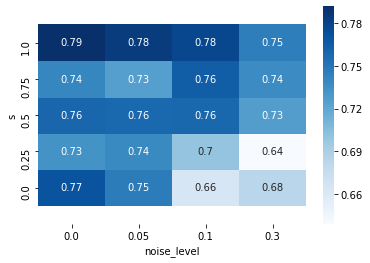

In [101]:
sns.heatmap(cds, cmap='Blues', annot=True)
plt.ylim(-0.5,5.5)

In [96]:
cds = res_ds.pivot_table(index='s',columns='noise_level',values='acc',aggfunc='std')
cds

noise_level,0.00,0.05,0.10,0.30
s,,,,
0.00,0.143176,0.255308,0.306363,0.233857
0.25,0.137381,0.171369,0.122592,0.235171
0.50,0.101497,0.128282,0.152624,0.133438
0.75,0.114049,0.132489,0.149178,0.203443
1.00,0.112748,0.130626,0.134884,0.125730


In [82]:
import seaborn as sns

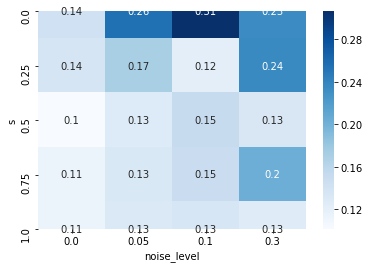

In [97]:
sns.heatmap(cds, cmap='Blues', annot=True)

In [19]:
import matplotlib.pyplot as plt

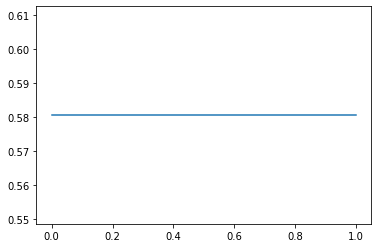

In [20]:
plt.plot([0,0.25,0.5,0.75,1], acs)